<a href="https://colab.research.google.com/github/vshalisko/GEE/blob/main/Colab/Landsat_ANN_test3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Uso de ANN para clasificacion de Landsat

In [ ]:
!pip install pyrsgis

Preparar el entorno

In [ ]:
import ee
import geemap
import random
import math, glob, time
import numpy as np
from pyrsgis import raster, convert
import matplotlib.pyplot as plt
from google.colab import drive

random.seed(2)

Conección con GEE

In [ ]:
# Trigger the authentication flow.
ee.Authenticate()

# Initialize the library.
ee.Initialize(project='ee-viacheslavs')

Coneccion con Google Drive para almacenar archivos

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


Lectura de capas de datos

In [ ]:
fecha_inicio_2015 = '2015-02-01'
fecha_final_2015 = '2015-05-30'
fecha_inicio_2020 = '2020-02-01'
fecha_final_2020 = '2020-05-30'

punto_interes = ee.Geometry.Point([-103.76, 19.75])
print(punto_interes.getInfo())

# filtrado de datos Landsat potencialemtne adecuados
L8_collection_2015 = ee.ImageCollection("LANDSAT/LC08/C02/T1_L2").filterBounds(punto_interes).filterDate(fecha_inicio_2015, fecha_final_2015).filter(ee.Filter.lessThan('CLOUD_COVER', 1))
print('Capas de datos filtrados 2015:', L8_collection_2015.size().getInfo())

# Cargar imagen de la colección (Landsat 8).
L8_image_2015 = L8_collection_2015.first()
image_meta_2015 = L8_image_2015.getInfo()
imagename_2015 = image_meta_2015.get('properties',{}).get('LANDSAT_PRODUCT_ID')
print('Imagen 2015 elegido:', imagename_2015)


L8_collection_2020 = ee.ImageCollection("LANDSAT/LC08/C02/T1_L2").filterBounds(punto_interes).filterDate(fecha_inicio_2020, fecha_final_2020).filter(ee.Filter.lessThan('CLOUD_COVER', 1))
print('Capas de datos filtrados 2020:', L8_collection_2020.size().getInfo())

# Cargar imagen de la colección (Landsat 8).
L8_image_2020 = L8_collection_2020.first()
image_meta_2020 = L8_image_2020.getInfo()
imagename_2020 = image_meta_2020.get('properties',{}).get('LANDSAT_PRODUCT_ID')
print('Imagen 2020 elegido:', imagename_2020)

# Load builtup 2015 (res 100 m)
ghs_built_image = ee.Image('JRC/GHSL/P2023A/GHS_BUILT_S/2015')
built_2015_lr = ghs_built_image.select('built_surface')

# Load builtup 2015 (res 10 m)
built_2015_hr = ee.Image('DLR/WSF/WSF2015/v1')

# blackBackground = ee.Image(0);




{'type': 'Point', 'coordinates': [-103.76, 19.75]}
Capas de datos filtrados 2015: 2
Imagen 2015 elegido: LC08_L2SP_029046_20150208_20200909_02_T1
Capas de datos filtrados 2020: 4
Imagen 2020 elegido: LC08_L2SP_029046_20200325_20200822_02_T1


Visualizar capas de datos (con uso de geemap).

Nota: no siempre funciona de forma correcta

In [ ]:
Map = geemap.Map()
# Center the map and display the image.
Map.centerObject(punto_interes, 8)

# Parametros de visualizacion para Landsat 8
vizParams_L8 = {
  'bands': ['SR_B5', 'SR_B4', 'SR_B3'],
   'min': 5000,
   'max': 15000
  #'gamma': [0.95, 1.1, 1]
}
# Parametros de visualizacion para Builtup LR
vizBuiltup_LR = {
   'min': 0,
   'max': 1,
  'palette': ['white','black']
}
# Parametros de visualizacion para Builtup HR
vizBuiltup_HR = {
  min: 0,
  max: 255,
  'palette': ['white','black']
}

# Agregar capas
Map.addLayer(L8_image_2020, vizParams_L8, 'Composición de falso color 2020', True, 0.5)
Map.addLayer(L8_image_2015, vizParams_L8, 'Composición de falso color 2015', True, 0.5)
Map.addLayer(built_2015_lr, vizBuiltup_LR, 'Builtup 2015 100m', True, 0.5)
Map.addLayer(built_2015_hr, vizBuiltup_HR, 'Builtup 2015 10m', True, 0.5)

# Presentar mapa
Map


Map(center=[19.75, -103.76], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchData…

Conversión de datos en numpy array para el analisis

In [ ]:
projection = L8_image_2015.projection().getInfo();
print(projection)
print(projection.get('crs'))

## Reproject label layer to L8 projection
built_2015_hr_reprojected = built_2015_hr.reproject(projection.get('crs'), projection.get('transform'))
#print(built_2015_hr_reprojected.getInfo())

# convert all to UTM in order to get good rectangle
#limites_geo = [-103.65,-103.05, 20.43, 20.95]
limites_utm = [640000, 702800, 2255000, 2310000]
pixel = 30
max_tile = 250000
utm13 = ee.Projection('EPSG:32613')

def segmentation(limits, pixel_size, max_tile_size, proj):
  alto = math.ceil((limits[3] - limits[2]) / pixel_size)
  print('Alto del segmento (pixeles)', alto)
  ancho = math.ceil(max_tile_size / alto)
  print('Ancho del segmento (pixeles)', ancho)
  incremento = ancho * pixel_size
  print('Ancho del segmento (unidades de proyeccion)', incremento)
  seq = list(np.arange(limits[0], limits[1], incremento))
  print('Secuencia de marcas de longitud')
  print(seq)
  segments = []
  for i in range(len(seq)-1):
    #print(seq[i], seq[i+1])
    segment = ee.Geometry.Rectangle([int(seq[i]), limites_utm[2], int(seq[i+1]), limites_utm[3]], proj, True, False)
    #print(segment)
    segments.append(segment)
  return segments

segment_list = segmentation(limites_utm, pixel, max_tile, utm13)

Map1 = geemap.Map()
bbox = ee.Geometry.Rectangle([limites_utm[0], limites_utm[2], limites_utm[1], limites_utm[3]], utm13, True, False)
Map1.centerObject(punto_interes, 8)
Map1.addLayer(bbox, {}, 'Area de estudio')
Map1

{'type': 'Projection', 'crs': 'EPSG:32613', 'transform': [30, 0, 551685, 0, -30, 2352915]}
EPSG:32613
Alto del segmento (pixeles) 1834
Ancho del segmento (pixeles) 137
Ancho del segmento (unidades de proyeccion) 4110
Secuencia de marcas de longitud
[640000, 644110, 648220, 652330, 656440, 660550, 664660, 668770, 672880, 676990, 681100, 685210, 689320, 693430, 697540, 701650]


Map(center=[19.75, -103.76], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchData…

In [ ]:
bands_L8 = ['SR_B2','SR_B3','SR_B4','SR_B5','SR_B6','SR_B7']
bands_B = ['settlement']

def tile_to_numpy(image, rectangle, bands):
  ## extraccion de bandas en un region rectangular
  image_tile = image.sampleRectangle(region=rectangle,defaultValue=0)
  first_band = image_tile.get(bands[0])
  band_array_np = np.array(first_band.getInfo())
  band_array_np = np.expand_dims(band_array_np, 2)
  for b in bands[1:]:
    b_arr = image_tile.get(b)
    b_arr_np = np.array(b_arr.getInfo())
    b_arr_np = np.expand_dims(b_arr_np, 2)
    #print(b_arr_np.shape)
    #print(band_array_np.shape)
    band_array_np = np.concatenate((band_array_np, b_arr_np), 2)
  return band_array_np

def merge_feature_array(image, segments, bands):
  ## combinaccion de segmentos
  array_feature = tile_to_numpy(image, segments[0], bands)
  print("New feature array", array_feature.shape)
  for segment in segments[1:]:
    feature_segment = tile_to_numpy(image, segment, bands)
    print("Feature segment", feature_segment.shape)
    array_feature = np.concatenate((array_feature, feature_segment), 1)
  print("Full new feature array", array_feature.shape)
  return array_feature


In [ ]:
# definición de un region pequeño para el analisis (GEO)
aoi0 = ee.Geometry.Polygon(
        [[[-103.42046006557397, 20.721686475573005],
          [-103.42046006557397, 20.694710560279958],
          [-103.39846006557397, 20.694710560279958],
          [-103.39846006557397, 20.721686475573005]]], None, False);
aoi1 = ee.Geometry.Polygon(
        [[[-103.39846006557397, 20.721686475573005],
          [-103.39846006557397, 20.694710560279958],
          [-103.36309782192163, 20.694710560279958],
          [-103.36309782192163, 20.721686475573005]]], None, False);


Definir un subconjunto pequeño para pruebas rapidas (features & target)

First test small feature array (102, 79, 6)
Second test small feature array (102, 124, 6)
Small test feature array (102, 203, 6)


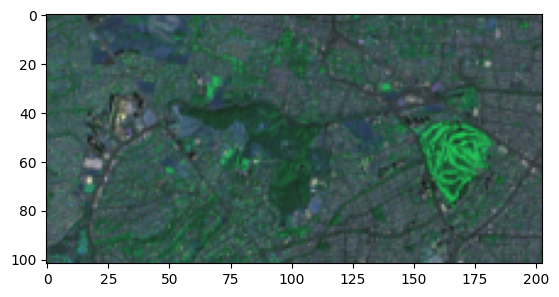

First test label array (102, 79, 1)
Second test label array (102, 124, 1)
Small test label array (102, 203, 1)


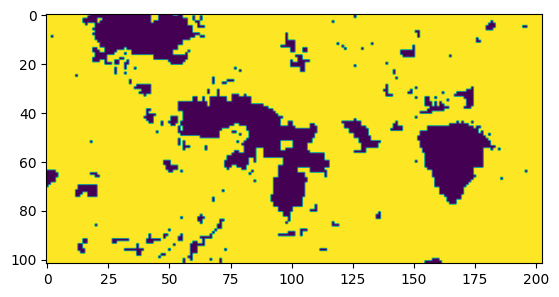

In [ ]:
array0 = tile_to_numpy(L8_image_2015, aoi0, bands_L8)
print("First test small feature array", array0.shape)
array1 = tile_to_numpy(L8_image_2015, aoi1, bands_L8)
print("Second test small feature array", array1.shape)

array_small_feature = np.concatenate((array0, array1), 1)
print("Small test feature array", array_small_feature.shape)

# Scale the data to [0, 255] to show as an RGB image.
rgb_img_test = (255*((array_small_feature - 5000)/30000)).astype('uint8')
plt.imshow(rgb_img_test[:,:,2:5])
plt.show()

arrayL0 = tile_to_numpy(built_2015_hr_reprojected, aoi0, bands_B)
print("First test label array", arrayL0.shape)
arrayL1= tile_to_numpy(built_2015_hr_reprojected, aoi1, bands_B)
print("Second test label array", arrayL1.shape)

array_small_labels = np.concatenate((arrayL0, arrayL1), 1)
print("Small test label array", array_small_labels.shape)

# Scale the data to [0, 255] to show as an RGB image.
B_img_test = (array_small_labels).astype('uint8')
plt.imshow(B_img_test[:,:,0])
plt.show()

Preparar datos de entrenamiento en zona de estudio para el año 2015

---



New feature array (1834, 138, 6)
Feature segment (1834, 138, 6)
Feature segment (1834, 138, 6)
Feature segment (1834, 138, 6)
Feature segment (1834, 138, 6)
Feature segment (1834, 138, 6)


Feature segment (1834, 138, 6)


Feature segment (1834, 138, 6)
Feature segment (1834, 138, 6)
Feature segment (1834, 138, 6)
Feature segment (1834, 138, 6)
Feature segment (1834, 138, 6)
Feature segment (1834, 138, 6)
Feature segment (1834, 138, 6)
Feature segment (1834, 138, 6)
Full new feature array (1834, 2070, 6)


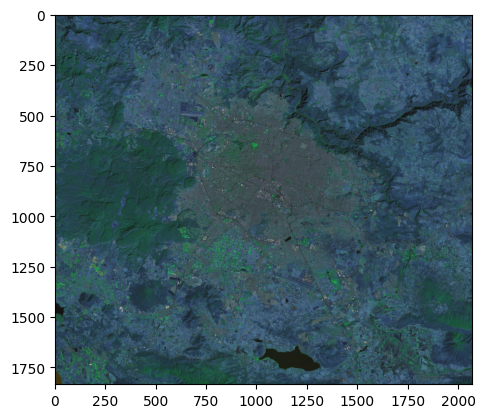

In [ ]:
array_feature_2015 = merge_feature_array(L8_image_2015, segment_list, bands_L8)

# Scale the data to [0, 255] to show as an RGB image.
rgb_img_new = (255*((array_feature_2015 - 5000)/30000)).astype('uint8')
plt.imshow(rgb_img_new[:,:,2:5])
plt.show()

Preparar datos de imagen 2020 para predicción

New feature array (1834, 138, 6)
Feature segment (1834, 138, 6)
Feature segment (1834, 138, 6)
Feature segment (1834, 138, 6)
Feature segment (1834, 138, 6)
Feature segment (1834, 138, 6)
Feature segment (1834, 138, 6)
Feature segment (1834, 138, 6)
Feature segment (1834, 138, 6)
Feature segment (1834, 138, 6)
Feature segment (1834, 138, 6)
Feature segment (1834, 138, 6)
Feature segment (1834, 138, 6)
Feature segment (1834, 138, 6)
Feature segment (1834, 138, 6)
Full new feature array (1834, 2070, 6)


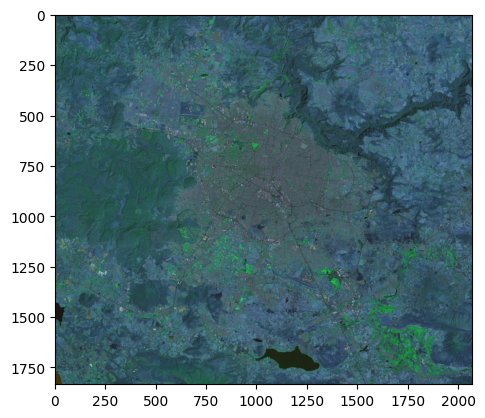

In [ ]:
array_feature_2020 = merge_feature_array(L8_image_2020, segment_list, bands_L8)

# Scale the data to [0, 255] to show as an RGB image.
rgb_img_new = (255*((array_feature_2020 - 5000)/30000)).astype('uint8')
plt.imshow(rgb_img_new[:,:,2:5])
plt.show()

New feature array (1834, 138, 1)
Feature segment (1834, 138, 1)
Feature segment (1834, 138, 1)
Feature segment (1834, 138, 1)
Feature segment (1834, 138, 1)
Feature segment (1834, 138, 1)
Feature segment (1834, 138, 1)
Feature segment (1834, 138, 1)
Feature segment (1834, 138, 1)
Feature segment (1834, 138, 1)
Feature segment (1834, 138, 1)
Feature segment (1834, 138, 1)
Feature segment (1834, 138, 1)
Feature segment (1834, 138, 1)
Feature segment (1834, 138, 1)
Full new feature array (1834, 2070, 1)


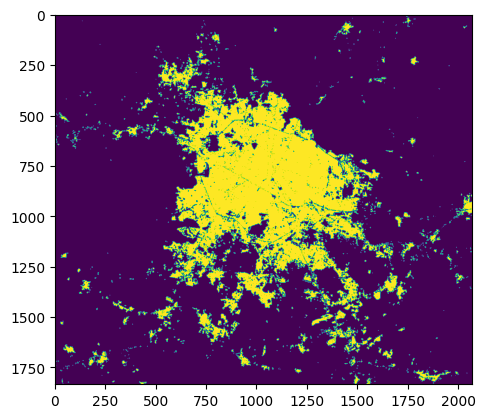

In [ ]:
array_target_2015 = merge_feature_array(built_2015_hr_reprojected, segment_list, bands_B)

# Scale the data to [0, 255] to show as an RGB image.
rgb_img_new = (array_target_2015).astype('uint8')
plt.imshow(rgb_img_new[:,:,0])
plt.show()

Guardar los conjuntos de datos concatenados (numpy array)

In [ ]:
# Save the arrays as .npy files
np.save('/content/drive/MyDrive/Colab Data/Gdl_2015_full_feature.npy', array_feature_2015)
np.save('/content/drive/MyDrive/Colab Data/Gdl_2020_full_feature.npy', array_feature_2020)
np.save('/content/drive/MyDrive/Colab Data/Gdl_2015_full_target.npy', array_target_2015)

Transformar datos para Keras

In [ ]:
## Datos de prueba pequeños
#array_full_t = np.transpose(array_small_feature, (2, 0, 1))
#array_labels_t = np.transpose(array_small_labels, (2, 0, 1))

## Datos de completos
array_full_2015_t = np.transpose(array_feature_2015, (2, 0, 1))
array_full_2020_t = np.transpose(array_feature_2020, (2, 0, 1))
array_labels_2015_t = np.transpose(array_target_2015, (2, 0, 1))

print(array_full_2015_t.shape)
print(array_full_2020_t.shape)
print(array_labels_2015_t.shape)

x_features_2015 = convert.array_to_table(array_full_2015_t)
x_features_2020 = convert.array_to_table(array_full_2020_t)
y_labels_2015 = convert.array_to_table(array_labels_2015_t)

nBands = x_features_2015.shape[1]

print(x_features_2015.shape)
print(x_features_2020.shape)
print(y_labels_2015.shape)

unique_values, occurrence_count = np.unique(y_labels_2015, return_counts=True)
print('Valores únicos de clases', unique_values)
print('Conteo de pixeles de valores únicos', occurrence_count)

# Normalise the data
y_labels_2015 = y_labels_2015 / 255
x_features_2015 = x_features_2015 / 32768
x_features_2020 = x_features_2020 / 32768

print(x_features_2015)
print(x_features_2020)
print(y_labels_2015)


(6, 1834, 2070)
(6, 1834, 2070)
(1, 1834, 2070)
(3796380, 6)
(3796380, 6)
(3796380, 1)
Valores únicos de clases [  0 255]
Conteo de pixeles de valores únicos [3108957  687423]
[[0.26785278 0.27770996 0.28768921 0.36019897 0.40881348 0.36032104]
 [0.26727295 0.27487183 0.28631592 0.36248779 0.41854858 0.36254883]
 [0.27008057 0.27639771 0.28997803 0.37054443 0.43188477 0.37158203]
 ...
 [0.22940063 0.23083496 0.22824097 0.23770142 0.24160767 0.23199463]
 [0.23052979 0.23327637 0.23202515 0.24179077 0.24905396 0.23532104]
 [0.23358154 0.23608398 0.23776245 0.2482605  0.26657104 0.24703979]]
[[0.26797485 0.28567505 0.30130005 0.40975952 0.43914795 0.37078857]
 [0.26873779 0.28512573 0.30169678 0.41021729 0.4432373  0.37139893]
 [0.27059937 0.29138184 0.30892944 0.41784668 0.45614624 0.38189697]
 ...
 [0.24645996 0.2588501  0.259552   0.33813477 0.33306885 0.29507446]
 [0.24685669 0.25622559 0.25784302 0.33401489 0.32971191 0.2979126 ]
 [0.24432373 0.2543335  0.25622559 0.29467773 0.319274

Subdividir datos de entrenamiento y control (2015)

In [ ]:
from sklearn.model_selection import train_test_split

xTrain, xTest, yTrain, yTest = train_test_split(x_features_2015, y_labels_2015, test_size=0.4, random_state=242)

print(xTrain.shape)
print(yTrain.shape)

print(xTest.shape)
print(yTest.shape)

print(xTrain)
print(yTrain)

# Reshape the data
xTrain = xTrain.reshape((xTrain.shape[0], 1, xTrain.shape[1]))
xTest = xTest.reshape((xTest.shape[0], 1, xTest.shape[1]))

print(xTrain.shape, xTest.shape)

(2277828, 6)
(2277828, 1)
(1518552, 6)
(1518552, 1)
[[0.28662109 0.31121826 0.33190918 0.42562866 0.53436279 0.45544434]
 [0.32907104 0.36123657 0.4045105  0.50134277 0.58779907 0.5135498 ]
 [0.24188232 0.24200439 0.24752808 0.29257202 0.2980957  0.28259277]
 ...
 [0.28170776 0.30508423 0.32705688 0.40585327 0.52792358 0.44308472]
 [0.31430054 0.34863281 0.36621094 0.45437622 0.49401855 0.4772644 ]
 [0.2618103  0.27328491 0.28622437 0.35571289 0.40170288 0.36004639]]
[[0.]
 [0.]
 [0.]
 ...
 [0.]
 [0.]
 [0.]]
(2277828, 1, 6) (1518552, 1, 6)


Entrenar la red neuronal (ANN) simple con 1 capa oculta

In [ ]:
from tensorflow import keras

# Define the parameters of the model
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(1, nBands)),
    keras.layers.Dense(14, activation='relu'),
    keras.layers.Dense(2, activation='softmax')])

# Define the accuracy metrics and parameters
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

# Run the model
model.fit(xTrain, yTrain, epochs=5)

Epoch 1/5
71183/71183 [==============================] - 187s 3ms/step - loss: 0.2020 - accuracy: 0.9266
Epoch 2/5
71183/71183 [==============================] - 215s 3ms/step - loss: 0.1661 - accuracy: 0.9381
Epoch 3/5
71183/71183 [==============================] - 242s 3ms/step - loss: 0.1620 - accuracy: 0.9395
Epoch 4/5
71183/71183 [==============================] - 256s 4ms/step - loss: 0.1607 - accuracy: 0.9402
Epoch 5/5
71183/71183 [==============================] - 263s 4ms/step - loss: 0.1599 - accuracy: 0.9405


In [ ]:
model.save('/content/drive/MyDrive/Colab Data/Gdl_2015_model_ANN_1hl.tensorflow')

In [ ]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score, roc_auc_score, cohen_kappa_score

# Predict for test data
yTestPredicted = model.predict(xTest)
yTestPredicted = yTestPredicted[:,1]

# Calculate and display the error metrics
roc_auc_raw = roc_auc_score(yTest, yTestPredicted)
yTestPredicted = (yTestPredicted>0.5).astype(int)
cMatrix = confusion_matrix(yTest, yTestPredicted)
accuracy = accuracy_score(yTest, yTestPredicted)
roc_auc = roc_auc_score(yTest, yTestPredicted)
kappa = cohen_kappa_score(yTest, yTestPredicted)
pScore = precision_score(yTest, yTestPredicted, average=None)
rScore = recall_score(yTest, yTestPredicted, average=None)
f1Score = f1_score(yTest, yTestPredicted, average=None)

print("Confusion matrix:\n", cMatrix)
print("\nExactitud (accuracy): %.3f," % accuracy)
print("\nKapa de Cohen: %.3f," % kappa)
print("\nROC AUC raw: %.3f," % roc_auc_raw)
print("\nROC AUC: %.3f," % roc_auc)
print("\nC1 precisión: %.3f, especificidad (recall): %.3f, f1: %.3f" % (pScore[0], rScore[0], f1Score[0]))
print("\nC2 precisión: %.3f, especificidad (recall): %.3f, f1: %.3f" % (pScore[1], rScore[1], f1Score[1]))

47455/47455 [==============================] - 129s 3ms/step
Confusion matrix:
 [[1191214   52157]
 [  40120  235061]]

Exactitud (accuracy): 0.939,

Kapa de Cohen: 0.799,

ROC AUC raw: 0.972,

ROC AUC: 0.906,

C1 precisión: 0.967, especificidad (recall): 0.958, f1: 0.963

C2 precisión: 0.818, especificidad (recall): 0.854, f1: 0.836


In [ ]:
x_features_2015_n = x_features_2015
x_features_2015_n = x_features_2015_n.reshape((x_features_2015_n.shape[0], 1, x_features_2015_n.shape[1]))

predicted_2015 = model.predict(x_features_2015_n)
print(predicted_2015)

118637/118637 [==============================] - 240s 2ms/step
[[0.991099   0.008901  ]
 [0.99610865 0.00389123]
 [0.99658185 0.00341817]
 ...
 [0.9986584  0.00134156]
 [0.99868923 0.00131077]
 [0.99899966 0.00100032]]


[[0.008901   0.00389123 0.00341817 ... 0.00806456 0.0103501  0.0128243 ]
 [0.00718091 0.00501711 0.0034839  ... 0.00813403 0.0097694  0.01138586]
 [0.00858715 0.00565902 0.0046982  ... 0.00572044 0.00797493 0.00954558]
 ...
 [0.25642624 0.2569843  0.2562582  ... 0.00096714 0.00162674 0.00138202]
 [0.2544002  0.25571355 0.25768346 ... 0.00239593 0.00450828 0.00474996]
 [0.2595218  0.2570744  0.25714937 ... 0.00134156 0.00131077 0.00100032]]


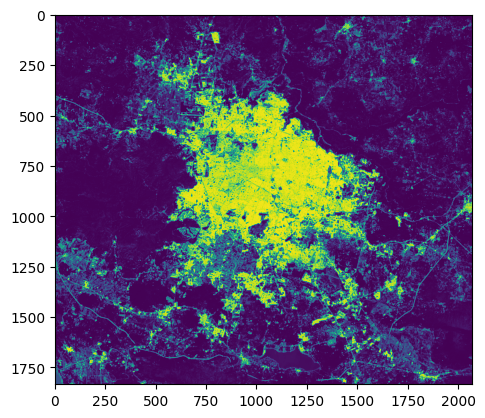

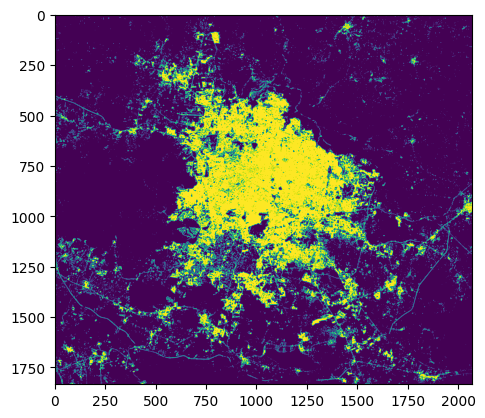

In [ ]:
#predicted = predicted * 255

prediction_2015 = np.reshape(predicted_2015[:,1], (array_target_2015.shape[0], array_target_2015.shape[1]))
print(prediction_2015)
B_img_pred_2015 = (prediction_2015).astype('float')
plt.imshow(B_img_pred_2015[:,:])
plt.show()
B1_img_pred_2015 = (prediction_2015>0.5).astype('uint8')
plt.imshow(B1_img_pred_2015[:,:])
plt.show()

In [ ]:
x_features_2020_n = x_features_2020
x_features_2020_n = x_features_2020_n.reshape((x_features_2020_n.shape[0], 1, x_features_2020_n.shape[1]))

predicted_2020 = model.predict(x_features_2020_n)
print(predicted_2020)

118637/118637 [==============================] - 226s 2ms/step
[[0.97912735 0.0208727 ]
 [0.98478603 0.015214  ]
 [0.9742537  0.02574628]
 ...
 [0.9911011  0.00889891]
 [0.99088    0.00912002]
 [0.9970041  0.00299595]]


[[0.0208727  0.015214   0.02574628 ... 0.01466197 0.01643618 0.01537746]
 [0.03240655 0.01789118 0.01563706 ... 0.016039   0.0200364  0.01387267]
 [0.01866261 0.02131132 0.01913459 ... 0.01238546 0.02026947 0.01114407]
 ...
 [0.2541913  0.25590572 0.25609678 ... 0.00510964 0.00149312 0.00313963]
 [0.2549353  0.2585894  0.25735503 ... 0.00412432 0.00350854 0.00486818]
 [0.2567805  0.25849843 0.25759873 ... 0.00889891 0.00912002 0.00299595]]


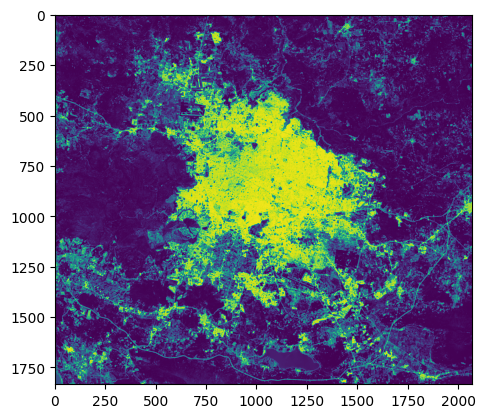

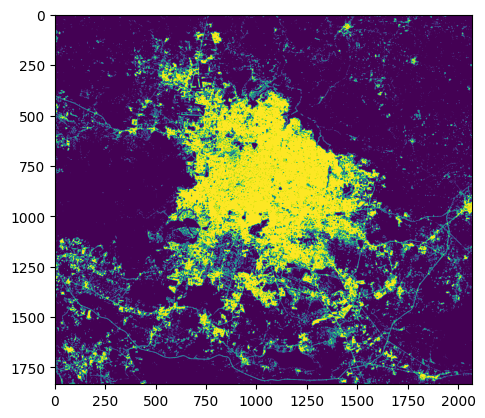

In [ ]:
prediction_2020 = np.reshape(predicted_2020[:,1], (array_target_2015.shape[0], array_target_2015.shape[1]))
print(prediction_2020)
B_img_pred_2020 = (prediction_2020).astype('float')
plt.imshow(B_img_pred_2020[:,:])
plt.show()
B1_img_pred_2020 = (prediction_2020>0.5).astype('uint8')
plt.imshow(B1_img_pred_2020[:,:])
plt.show()

In [ ]:
# Save the arrays as .npy files
np.save('/content/drive/MyDrive/Colab Data/Gdl_2015_prediction_float.npy', prediction_2015)
np.save('/content/drive/MyDrive/Colab Data/Gdl_2020_prediction_float.npy', prediction_2020)